In [1]:
import pickle
import numpy as np
import pandas as pd
import json
import itertools
import csv
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
import logging 

from datahelper import DataHelper
from cross_validation import CrossValidation
import models

In [2]:
# Suppress TensorFlow messages and warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Suppress Matplotlib messages
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.ERROR) 

In [3]:
PATH_TO_DATA = './data/'
PATH_TO_RESULTS = PATH_TO_DATA + 'results/'

### Model creation and training

    1. Define model parameters. 

Parameters that can be set include parameters that control the sampling (e.g., batch size, ratio of negative to positive samples), hyperparameters for cross validation (e.g., number of epochs, learning rate, regularization), and parameters specific to the model (e.g., hidden size/ number of latent dimensions). 
The list of all parameters can be found in `cross_validation.py`.

Additionally, a range of values may be specified for each parameter and the cross validation pipeline will be run for all combinations of parameters.

In [4]:
model = models.NECTRModel

parameters = [{'name': 'hidden_size', 'min': 15, 'max': 25, 'step': 5}, 
              {'name': 'n_epoch', 'value': 2},
              {'name': 'nectr_n_epoch_completion', 'value': 2}]

    2. Setup DataHelper utils

In [5]:
DataHelper.setup(PATH_TO_DATA)

    3. Setup cross validation

In [6]:
cv = CrossValidation(datahelper=DataHelper, parameters=parameters)

    4. Run the cross validation pipeline

In [7]:
cv.run_pipeline(model, PATH_TO_RESULTS)

----------------------------------------------------------------------
Creating the model:  NECTR ...
----------------------------------------------------------------------
Splitting the dataset for cross-validation...
Total number of triples in the dataset: 426710
Number of features in the dataset: 185123 triples
Number of solutions in the dataset: 241587 triples
Training set (solutions): 168738 triples
Training set (features): 185123 triples
Validation set (solutions): 48290 triples
Test set (solutions): 24559 triples
----------------------------------------------------------------------
Training the model using parameters:  {'hidden_size': 15, 'n_epoch': 2, 'nectr_n_epoch_completion': 2} ...
Training the tensor factorization component (for the completion loss)...
Epoch= 0 loss= 207733.027053833
Epoch= 1 loss= 95044.87618541718
Training both tensor factorization and neural network components (overall completion and recommendation loss)...
Epoch= 0 loss= 4417658.910644531
Epoch= 1 los

### Intepretation of cross validation results

    1. Load the results

In [8]:
with open(PATH_TO_RESULTS + 'NECTR_results.pickle', 'rb') as fp:
    results = pickle.load(fp, encoding='latin1')
    
metrics = [[results['best'], results['test']]]

    2. Compare different experiments based on the metrics

In [9]:
names = ["mean_rank_raw", "median_rank_raw", "mrr_raw", "hits_top10_raw", "hits_top10_perc_raw", "histogram_perc_rank_raw",
             "histogram_num_rank_raw",
             "mean_rank_in_category_raw", "median_rank_in_category_raw", "mrr_in_category_raw",
             "hits_top10_in_category_raw", "hits_top10_perc_in_category_raw",
             "histogram_perc_rank_in_category_raw", "histogram_num_rank_in_category_raw", "mean_rank_filtered",
             "median_rank_filtered", "mrr_filtered", "hits_top10_filtered", "hits_top10_perc_filtered", "histogram_perc_rank_filtered",
             "histogram_num_rank_filtered", "mean_rank_in_category_filtered", "median_rank_in_category_filtered",
             "mrr_in_category_filtered", "hits_top10_in_category_filtered", "hits_top10_perc_in_category_filtered", "histogram_perc_rank_in_category_filtered",
             "histogram_num_rank_in_category_filtered", "recall_raw", "recall_filtered"]

histograms = ["histogram_perc_rank_raw", "histogram_num_rank_raw", "histogram_perc_rank_in_category_raw", 
              "histogram_num_rank_in_category_raw", "histogram_perc_rank_filtered", "histogram_num_rank_filtered", 
              "histogram_perc_rank_in_category_filtered", "histogram_num_rank_in_category_filtered"]

In [10]:
df_metrics = pd.DataFrame(metrics, columns=['parameter', 'metrics'])
df_metrics.index = df_metrics.parameter
df_metrics.drop('parameter', axis=1, inplace=True)

temp = df_metrics['metrics'].apply(lambda x: pd.Series(x)) \
        .rename(columns={i: names[i] for i in range(len(names))})
    
df_metrics = pd.concat([df_metrics, temp], axis=1).drop('metrics', axis=1)

df_histograms = df_metrics[histograms]
df_metrics = df_metrics[df_metrics.columns.difference(histograms)]

df_metrics = df_metrics[["mrr_filtered", "hits_top10_perc_filtered", "hits_top10_filtered", "mean_rank_filtered", 
                         "median_rank_filtered", "recall_filtered", "mrr_raw", "hits_top10_perc_raw", "hits_top10_raw", 
                         "mean_rank_raw", 
                         "median_rank_raw", "recall_raw", "mrr_in_category_filtered", "hits_top10_perc_in_category_filtered", 
                         "hits_top10_in_category_filtered", "mean_rank_in_category_filtered", 
                         "median_rank_in_category_filtered","mrr_in_category_raw", "hits_top10_perc_in_category_raw", 
                         "hits_top10_in_category_raw", "mean_rank_in_category_raw", "median_rank_in_category_raw", ]]

df_metrics

,mrr_filtered,hits_top10_perc_filtered,hits_top10_filtered,mean_rank_filtered,median_rank_filtered,recall_filtered,mrr_raw,hits_top10_perc_raw,hits_top10_raw,mean_rank_raw,...,mrr_in_category_filtered,hits_top10_perc_in_category_filtered,hits_top10_in_category_filtered,mean_rank_in_category_filtered,median_rank_in_category_filtered,mrr_in_category_raw,hits_top10_perc_in_category_raw,hits_top10_in_category_raw,mean_rank_in_category_raw,median_rank_in_category_raw
parameter,,,,,,,,,,,,,,,,,,,,,
"{""hidden_size"": 20, ""n_epoch"": 2, ""nectr_n_epoch_completion"": 2}",0.179406,0.813505,0.277849,205.451441,46.0,"[0.5222244482673601, 0.6289308648283302, 0.701...",0.115913,0.808172,0.235355,212.769376,...,0.360978,0.576262,0.39157,20.629762,11.333333,0.360978,0.576262,0.39157,20.629762,11.333333


    3. Extract additional metrics from the histogram info

In [11]:
parameters = json.loads(df_metrics.index[0])
for i, k in enumerate(parameters.keys()):
    df_metrics.insert(i, k, 0)
    
for index, row in df_metrics.iterrows():
    parameters = json.loads(index)
    for k in parameters.keys():
        df_metrics.loc[index, k] = parameters[k]
    
    for i in range(1, 11):
        df_metrics.loc[index, 'hits_top_' + str(i) + '_perc_filtered'] = \
            df_histograms.loc[index, 'histogram_perc_rank_filtered'][0][:i].sum() / \
            df_histograms.loc[index, 'histogram_perc_rank_filtered'][0].sum()
    
    for i in range(1, 11):                
        df_metrics.loc[index, 'hits_top_' + str(i) + '_num_filtered'] = \
            df_histograms.loc[index, 'histogram_num_rank_filtered'][0][:i+1].sum() / \
            df_histograms.loc[index, 'histogram_num_rank_filtered'][0].sum()
    
    for i in range(1, 11):
        df_metrics.loc[index, 'hits_top_' + str(i) + '_perc_raw'] = \
            df_histograms.loc[index, 'histogram_perc_rank_raw'][0][:i].sum() / \
            df_histograms.loc[index, 'histogram_perc_rank_raw'][0].sum()
    
    for i in range(1, 11):
        df_metrics.loc[index, 'hits_top_' + str(i) + '_num_raw'] = \
            df_histograms.loc[index, 'histogram_num_rank_raw'][0][:i+1].sum() / \
            df_histograms.loc[index, 'histogram_num_rank_raw'][0].sum()

In [12]:
df_metrics

,hidden_size,n_epoch,nectr_n_epoch_completion,mrr_filtered,hits_top10_perc_filtered,hits_top10_filtered,mean_rank_filtered,median_rank_filtered,recall_filtered,mrr_raw,...,hits_top_1_num_raw,hits_top_2_num_raw,hits_top_3_num_raw,hits_top_4_num_raw,hits_top_5_num_raw,hits_top_6_num_raw,hits_top_7_num_raw,hits_top_8_num_raw,hits_top_9_num_raw,hits_top_10_num_raw
parameter,,,,,,,,,,,,,,,,,,,,,
"{""hidden_size"": 20, ""n_epoch"": 2, ""nectr_n_epoch_completion"": 2}",20,2,2,0.179406,0.813505,0.277849,205.451441,46.0,"[0.5222244482673601, 0.6289308648283302, 0.701...",0.115913,...,0.052473,0.090753,0.123527,0.144946,0.160172,0.176688,0.194581,0.209978,0.22357,0.235355


    4. Store the results

In [13]:
df_metrics.T.to_csv(PATH_TO_RESULTS + 'NECTR_results.csv', sep=';')

### Visualization of embeddings

In [14]:
categories = pd.read_csv(PATH_TO_DATA + 'Categories.csv', sep=';')
display_categories = {'EnergyMeter': 'EnergyMeter', 'IPC': 'IPC', 'IoSystem': 'IoSystem', 'Panel': 'Panel', 
                      'PowerSupplie': 'PowerSupply', 'Software': 'Software', 'Steuerungen': 'Controller', 'Switche': 'Switch',
                     'CablesAndPlugs': 'CableAndPlug', 'IndustrialCommunication': 'IndustrialCommunication',
                     'IndustrialControls': 'IndustrialControl', 'IoSystems': 'IoSystem', 'Controller': 'Controller', 
                      'Ipc': 'IPC'}

def get_category_display_name(x):
    return display_categories[x]

categories['category'] = categories['category'].apply(lambda x: get_category_display_name(x))
temp = categories.apply(lambda x: {int(i): x.name for i in x['entity_id'].split(',')}, axis=1).values.tolist()
item2cat = {k: v for i in temp for k, v in i.items()}
len(categories)

8

In [15]:
def get_category(row):
    if row['type'] == 'item' and row['id'] in item2cat:
        return categories.iloc[item2cat[int(row['id'])]]['category']
    else:
        return 'Unknown'

    1. Load the entity embeddings

In [16]:
with open(PATH_TO_RESULTS + 'NECTR_RecommenderSystem.pickle', 'rb') as fp:
    data = pickle.load(fp, encoding='latin1')

df_entity2id, entity_embeddings = data['entity2id'], data['item_embeddings']
df_entity2id['category'] = df_entity2id.apply(lambda row: get_category(row), axis=1)

print('entity_embeddings', entity_embeddings.shape)

entity_embeddings (3003, 25)


    2. Extract the item embeddings

In [17]:
items = df_entity2id[(df_entity2id['category'] != 'Unknown')]
item_embeddings = entity_embeddings[items.index.tolist()]

print('item_embeddings', item_embeddings.shape)

item_embeddings (355, 25)


    3. Apply PCA to reduce the embeddings to 2 dimensions. 

Other dimensionality reduction techniques, such as t-SNE, may also be applied and the results may be visualized in a similar fashion. 

In [18]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(item_embeddings)
embeddings_2d.shape

(355, 2)

    4. Plot a scatter plot of the items colored by category. 

It can be seen that the items form clusters based on their categories.

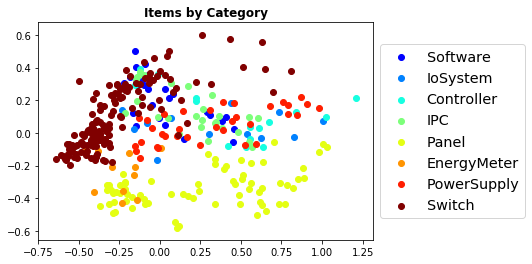

In [19]:
x = embeddings_2d[:, 0]
y = embeddings_2d[:, 1]
classes = items['category'].tolist()
unique = list(set(classes))
colors = [plt.cm.jet(float(i+1)/len(unique)) for i,_ in enumerate(unique)]

temp = []
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
    
    temp += list(zip(xi, yi, itertools.repeat(str(u))))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-large')
plt.title('Items by Category', fontweight='bold')
# plt.savefig('items_by_category.png', bbox_inches='tight')
plt.show()
plt.close()

with open(PATH_TO_RESULTS + 'items_by_category.csv', 'w', newline='') as fp:
    writer = csv.writer(fp, delimiter=' ')
    writer.writerow(['x', 'y', 'label'])
    writer.writerows(temp)